### Imports

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('../'))
from mri import MRI


%load_ext autoreload
%autoreload 2

### Data

In [2]:
# Load the MRI data from the file
file_path = '../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz'
mri = MRI(file_path)

00:35:02 | Reading data from ../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_8.nii.gz


00:35:02 | Displaying relevant brain slices


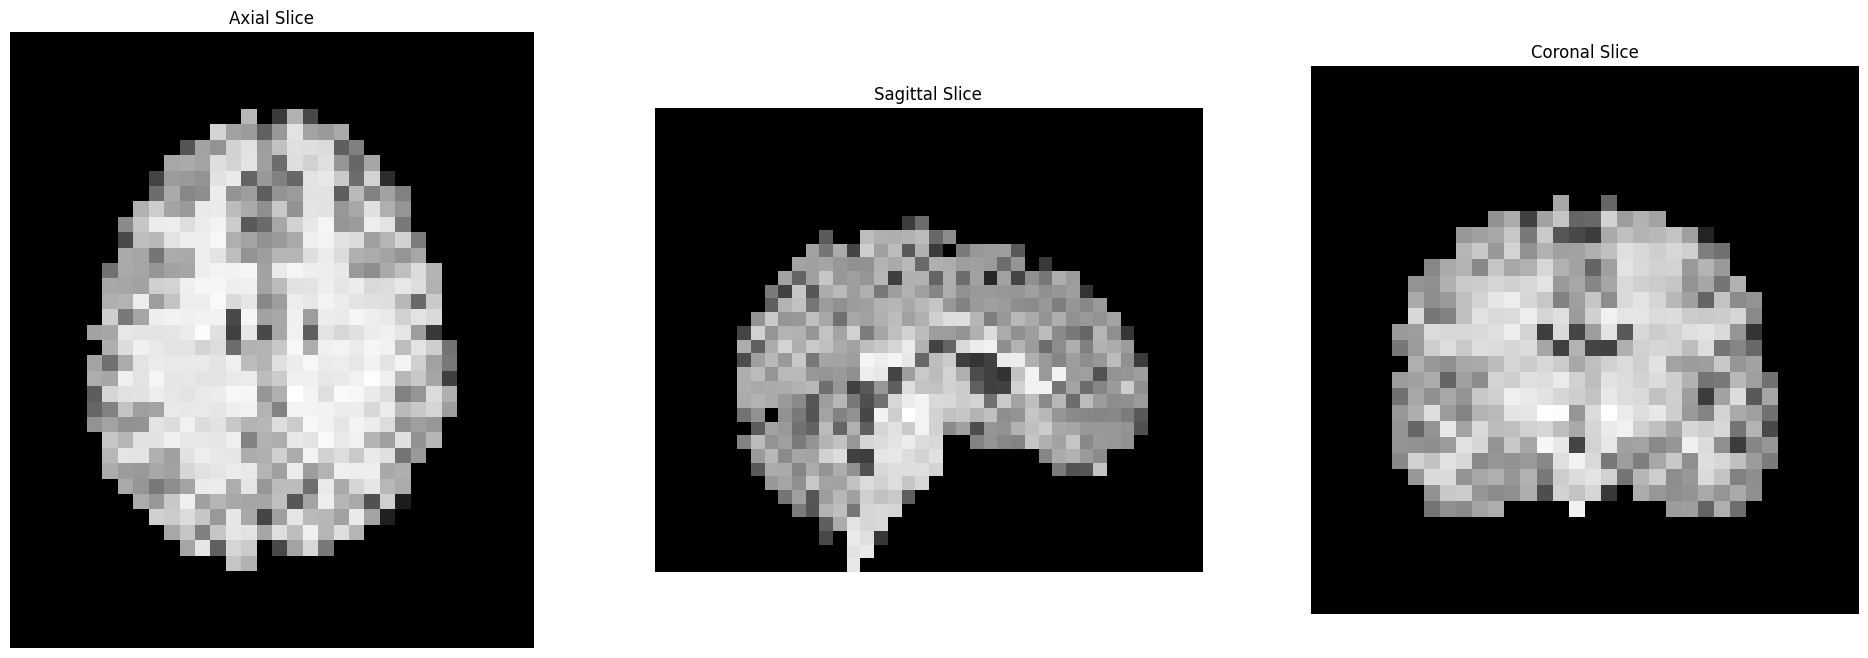

In [3]:
mri.display_relevant_brain_slices()

In [4]:
print(f"Voxel grid size: {mri.data.shape}")
print(f"Total number of points in MRI: {mri.data.flatten().shape[0]}")

Voxel grid size: (34, 40, 34)
Total number of points in MRI: 46240


In [5]:
import torch
from nn import NeuralNet
from utils import set_seed, get_device

In [6]:
set_seed()
device = get_device()

------------------------------------------------------------
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
	Allocated: 0.0 GB
	Reserved:  0.0 GB
------------------------------------------------------------


In [7]:
# Define the dimensions of the MRI
x_dim, y_dim, z_dim = mri.data.shape

# Create range vectors for each dimension
x_range = torch.arange(x_dim)
y_range = torch.arange(y_dim)
z_range = torch.arange(z_dim)

# Create a mesh grid
x_grid, y_grid, z_grid = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

# Combine and reshape the grids to create a list of coordinates
voxel_grid = torch.stack((x_grid, y_grid, z_grid), dim=-1).reshape(-1, 3)

In [8]:
voxel_grid

tensor([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  0,  2],
        ...,
        [33, 39, 31],
        [33, 39, 32],
        [33, 39, 33]])

In [9]:
def normalize_coordinates(grid):
    """
    Normalize the coordinates of the grid to be between -1 and 1.

    :param grid: The coordinate grid (tensor of shape (N, 3))
    :return: Normalized grid (tensor of shape (N, 3))
    """
    # Find the maximum dimension sizes
    max_values = grid.max(0)[0]

    # Normalize the grid
    normalized_grid = (grid - max_values / 2) / (max_values / 2)
    return normalized_grid

In [10]:
def fourier_feature_mapping(P, L):
    """
    Fourier feature mapping for a point P.

    :param P: Input point (tensor of shape (..., 3))
    :param L: The number of frequencies to use in the Fourier feature mapping
    :return: Fourier features of P (tensor of shape (..., 2L))
    """
    # Sample B from Gaussian distribution
    B = torch.randn(L, 3)

    # Compute 2πBP (shape will be (..., L, 3))
    BP = 2 * torch.pi * torch.matmul(P.float(), B.T)

    # Concatenate cos and sin features
    fourier_features = torch.cat([torch.cos(BP), torch.sin(BP)], dim=-1)

    return fourier_features

In [11]:
# Assuming coordinate_grid is your meshgrid with shape (N, 3), where N is the number of points
normalized_grid = normalize_coordinates(voxel_grid)

In [12]:
# Fourier feature mapping for the normalized grid
L = 128  # Number of frequencies
features_grid = fourier_feature_mapping(normalized_grid, L)

In [13]:
features_grid.shape

torch.Size([46240, 256])

In [14]:
features_grid

tensor([[-0.9837,  0.7830,  0.7747,  ...,  0.9772, -0.4279, -0.7624],
        [-0.9964,  0.9180,  0.6914,  ...,  0.9098, -0.4868, -0.8171],
        [-0.9999,  0.9896,  0.5978,  ...,  0.8008, -0.5436, -0.8652],
        ...,
        [-0.9999,  0.9896,  0.5978,  ..., -0.8008,  0.5436,  0.8652],
        [-0.9964,  0.9180,  0.6914,  ..., -0.9098,  0.4868,  0.8171],
        [-0.9837,  0.7830,  0.7747,  ..., -0.9772,  0.4279,  0.7624]])

### Training

In [21]:
net = NeuralNet()
print(features_grid.shape)

net(features_grid[:2500]).shape

torch.Size([46240, 256])


torch.Size([2500, 1])

In [26]:
indices = torch.randperm(features_grid.shape[0])

In [33]:
batch_size = 2500
net(features_grid[indices[:batch_size]])

tensor([[0.4946],
        [0.4704],
        [0.4741],
        ...,
        [0.4839],
        [0.5134],
        [0.3441]], grad_fn=<SigmoidBackward0>)

In [63]:
# Get intensity value for a point in the voxel grid
voxel_grid_np = voxel_grid.numpy()
point = tuple(voxel_grid_np[0])
mri.data[point]

-0.0

In [65]:
mri.data.flatten().shape

(46240,)